In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 100)
%load_ext autoreload
%autoreload 2

In [2]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

# Read Data

In [3]:
# path = 'C:/Users/robin.opdam/Google Drive/Thesis (Msc)/Thesis_shared_files/'
path = '/Users/Robin/Google Drive/Thesis (Msc)/Thesis_shared_files/'
data_path = 'data/'

# Full datasets

In [49]:
# Amazon
df_am = pd.read_pickle(path + data_path + 'Amazon/Amazon_full')
# subsets
names_am = ['Amazon_05_users', 'Amazon_01_users', 'Amazon_005_users', 'Amazon_001_users']

# MovieLens
df_ml = pd.read_pickle(path + data_path + 'ML/ML_full')
# subsets
names_ml = ['ML_05_users', 'ML_01_users', 'ML_005_users', 'ML_001_users']

In [50]:
df_am.head()

,user,item,datetime,rating
40273,A2X8QS4ZWXW7QP,B0000ZCE0O,2003-05-26,5.0
32383,ACJQVWGHRRLHJ,B0000TIKK8,2004-01-12,5.0
393270,A4SMAB99DG0AT,B000GAWSEU,2004-11-11,4.0
46906,A2PUJ083AYU5Y1,B0001KOBJ0,2004-12-20,3.0
46905,A31RMV81JXPB2E,B0001KOBJ0,2005-01-05,2.0


In [8]:
def get_stats(df):
    user_ratings = df.groupby('user')['rating'].count()
    item_ratings = df.groupby('item')['rating'].count()
    norpu = user_ratings.mean()
    norpi = item_ratings.mean()
    total_users = df.user.unique().size
    total_items = df.item.unique().size
    sparseness = 1 - len(df) / (len(df['user'].unique()) * len(df['item'].unique()))
    
    print('rows ', len(df), 
          '\n#ratings/user', round(norpu,2), 
          '\n#ratings/item', round(norpi,2), 
          '\naverage rating', "{0:.2f}".format(np.average(df['rating'])), 
          '\n#users ', df['user'].unique().size, 
          '\n#items ', df['item'].unique().size, 
          '\nsparse ', round(sparseness,5))

In [ ]:
def parse(path):
  g = gzip.open(path, 'r')
  for l in g:
    yield json.loads(l)

In [ ]:
import pandas as pd
import gzip
import json

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('Clothing_Shoes_and_Jewelry_5.json.gz')

In [ ]:
df.head()

In [ ]:
get_stats(df_am)

In [ ]:
get_stats(df_ml)

# Splits
- 0.5 * total users
- 0.1 * total users
- 0.05 * total users
- 0.01 * total users

In [ ]:
splits = [0.5, 0.1, 0.05, 0.01]

## Leave users out

In [ ]:
from Data_prep import leave_users_out
def data_split(df, splits, names, store_path):
    total_users = len(df.user.unique())

    for i, split in enumerate(splits):
        n_users = int(split * total_users)
        print('File:', names[i], ' #Users:', n_users)
        leftovers, new_df = leave_users_out(df, n_users)
        new_df.to_pickle(store_path + names[i])

In [ ]:
df_am['item_id'] = df_am.item.astype('category').cat.codes
df_am['user_id'] = df_am.user.astype('category').cat.codes

In [ ]:
df_ml['item_id'] = df_ml.item.astype('category').cat.codes
df_ml['user_id'] = df_ml.user.astype('category').cat.codes

## Splits Amazon

In [ ]:
store_path = path + data_path + 'Amazon/'
data_split(df_am, splits, names_am, store_path)

## Splits MovieLens

In [ ]:
store_path = path + data_path + 'ML/'
data_split(df_ml, splits, names_ml, store_path)

# Time Sorting Per User

In [ ]:
def time_sort_user(names, data_path):
    for name in names:
        from progressbar import ProgressBar
        pbar = ProgressBar()
        df = pd.read_pickle(data_path + name)
        users = df.user.unique()
        new_df = pd.DataFrame(columns=list(df))
        for u in pbar(users):
            df_u = df[df['user']==u]
            df_u = df_u.sort_values(by='datetime')
            new_df = pd.concat([new_df, df_u])
        new_df.to_pickle(data_path + name)    

In [ ]:
path + data_path + 'Amazon/' + names_am[0]

In [ ]:
# Amazon
file_path = path + data_path + 'Amazon/'
time_sort_user([names_am[0]], file_path)

In [ ]:
names_ml[:3]

In [ ]:
# MovieLens
file_path = path + data_path + 'ML/'
time_sort_user(names_ml[:3], file_path)

# Exploration

In [368]:
import matplotlib.gridspec as gridspec
import matplotlib.pylab as pl

def eda_plots(df, title, size=(20,16), store_path=''):
    
    user_counts = df.groupby('user_id')['item_id'].count()
    item_counts = df.groupby('item_id')['user_id'].count().sort_values(ascending=True)
    norpu = user_counts.mean()
    norpi = item_counts.mean()
    total_users = df.user.unique().size
    total_items = df.item.unique().size
    sparseness = 1 - len(df) / (len(df['user'].unique()) * len(df['item'].unique()))
    
    print('rows ', len(df), 
          '\n#ratings/user', round(norpu,2), 
          '\n#ratings/item', round(norpi,2), 
          '\naverage rating', "{0:.2f}".format(np.average(df['rating'])), 
          '\n#users ', df['user'].unique().size, 
          '\n#items ', df['item'].unique().size, 
          '\nsparse ', round(sparseness,5))
    
    fig = plt.figure(figsize=size)
#     fig.suptitle(title, x=0.5, y=0.95, fontsize=22)
    gs = fig.add_gridspec(2,2, wspace=0.4, hspace=0.4)
    
    f_ax1 = fig.add_subplot(gs[0,0])
    plt.hist(df.rating, bins=5)
    plt.title('Rating Distribution')
    plt.xlabel('Rating')
    plt.xticks(range(1,6))
    plt.ylabel('Count')
    
    f_ax2 = fig.add_subplot(gs[0,1])
    plt.hist(df.datetime, bins = 20)
    plt.xlabel('Time of Rating (years)')
    plt.ylabel('Count')
    plt.title('Time Distribution of Ratings')

    f_ax3 = fig.add_subplot(gs[1,0])
    plt.hist(item_counts, bins = 1000)
    plt.xlim([0,50])
    plt.title('Number of Ratings per Item')
    plt.xlabel('Reviews per Item')
    plt.ylabel('Count')
    plt.xticks(range(0,50,5))
    
    f_ax4 = fig.add_subplot(gs[1,1])
    plt.hist(user_counts, bins = 150)
    plt.xlim([0,50])
    plt.title('Number of Reviews per User')
    plt.xlabel('Reviews per User')
    plt.ylabel('Count')
    plt.xticks(range(0,50,5))

    if len(store_path) > 0:
        fig.savefig(store_path, bbox_inches='tight')
        
    plt.show()

In [369]:
plt.rcParams.update({'font.size':18})

rows  1058788 
#ratings/user 8.72 
#ratings/item 4.28 
average rating 4.28 
#users  121372 
#items  247465 
sparse  0.99996


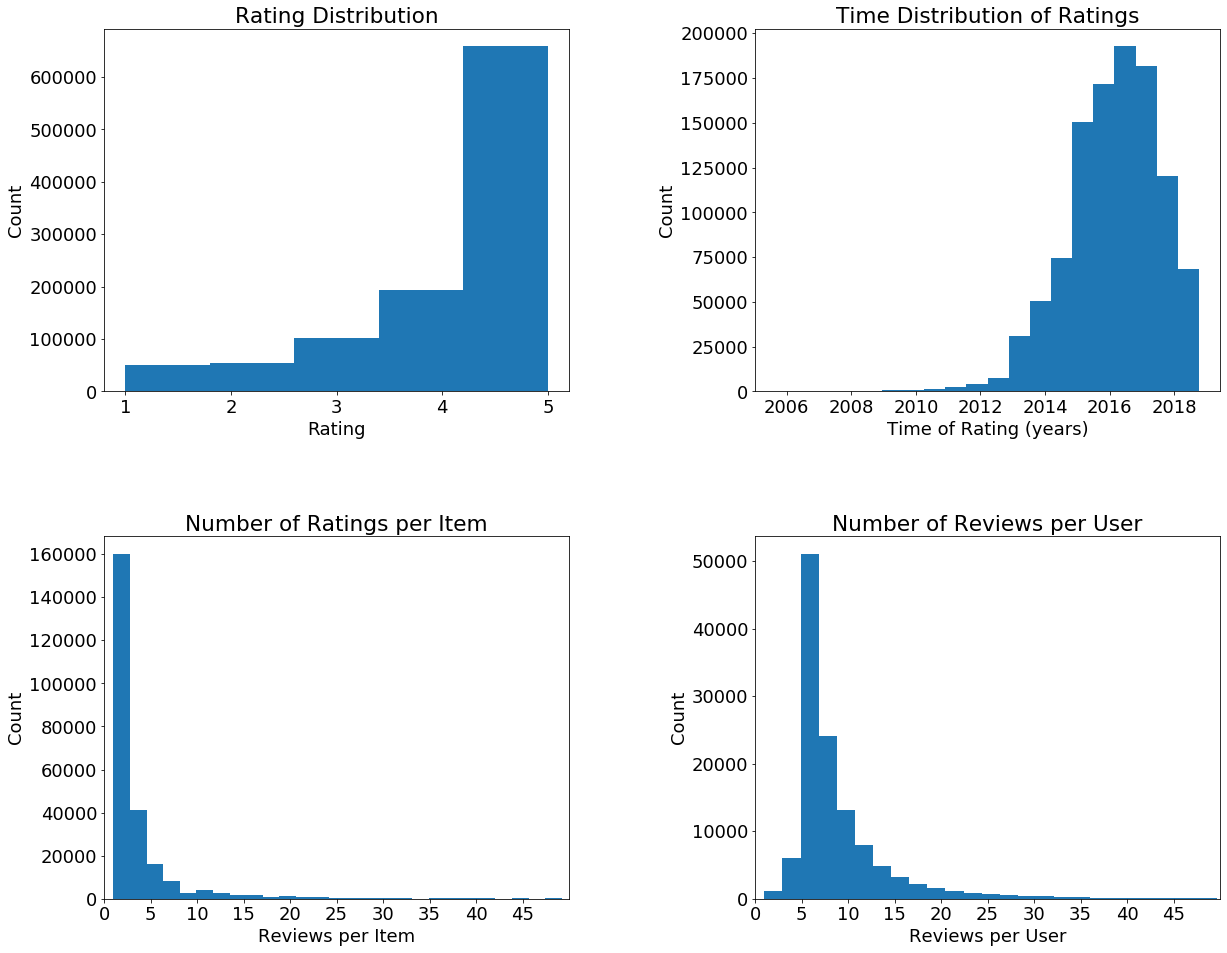

In [370]:
store_name = 'EDA_am_01'
store_path = path + 'Plots/EDA/' + store_name
title = 'Exploratory Data Analysis Amazon 10% of Users'
eda_plots(am, title, store_path=store_path)

In [286]:
ml.groupby('item_id')['rating'].count().sort_values(ascending=False)[:20]

item_id
314     8272
351     8198
292     7968
585     7428
2480    7312
257     6884
475     6434
522     6120
108     5881
2867    5870
581     5752
1166    5746
0       5709
4887    5627
49      5535
1168    5472
1179    5456
2766    5440
840     5261
5840    5191
Name: rating, dtype: int64

In [66]:
am['item_id'] = am.item.astype('category').cat.codes
am['user_id'] = am.user.astype('category').cat.codes

In [68]:
item_counts_ml = ml.groupby('item_id')['user_id'].count().sort_values(ascending=False)
item_counts_am = am.groupby('item_id')['user_id'].count().sort_values(ascending=False)

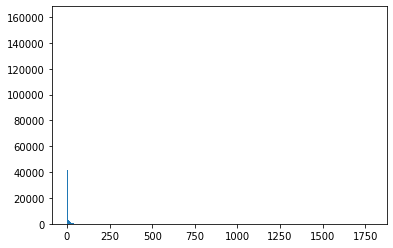

In [211]:
plt.hist(item_counts_am, bins=1000)
plt.show()

In [32]:
from brokenaxes import brokenaxes

In [74]:
len(item_counts_am)

247465

In [202]:
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

In [ ]:
x = item_counts_ml.index
y = item_counts_ml
fig, ax = plt.subplots(figsize=(10,8))

ax.scatter(x,y, s=10)
plt.show()

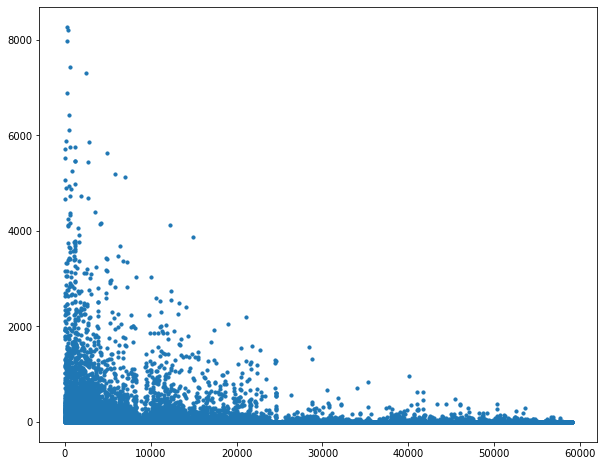

In [207]:
x = item_counts_ml.index
y = item_counts_ml
fig, ax = plt.subplots(figsize=(10,8))

ax.scatter(x,y, s=10)
plt.show()

# Create Am similar to ML

In [98]:
am = pd.read_pickle(path + 'Data/Amazon/Amazon_01_users')
ml =  pd.read_pickle(path + 'Data/ML/ML_01_users')

In [99]:
longest_users = pd.DataFrame(am.groupby('user_id')['item_id'].count().sort_values(ascending=False)[:len(ml.user_id.unique())].index).set_index('user_id')

In [100]:
am.set_index('user_id', inplace=True)
am_like_ml = longest_users.join(am).reset_index()

In [109]:
am_like_ml.to_pickle(path + 'Data/Amazon/am_like_ml_01')

# Appendix

## Old EDA with fig, axes

In [ ]:
# def eda_plots(df, title, size=(10,8)):
#     user_ratings = df.groupby('user')['rating'].count()
#     item_ratings = df.groupby('item')['rating'].count()
#     norpu = user_ratings.mean()
#     norpi = item_ratings.mean()
#     total_users = df.user.unique().size
#     total_items = df.item.unique().size
#     sparseness = 1 - len(df) / (len(df['user'].unique()) * len(df['item'].unique()))
    
#     print('rows ', len(df), 
#           '\n#ratings/user', round(norpu,2), 
#           '\n#ratings/item', round(norpi,2), 
#           '\naverage rating', "{0:.2f}".format(np.average(df['rating'])), 
#           '\n#users ', df['user'].unique().size, 
#           '\n#items ', df['item'].unique().size, 
#           '\nsparse ', round(sparseness,5))
    
    
#     figure, axes = plt.subplots(nrows=2, ncols=2, figsize=size)
#     figure.suptitle(title)
#     figure.subplots_adjust(wspace=0.4, hspace=0.4)
    
#     axes[0,0].hist(df.rating, bins=5)
#     axes[0,0].set_title('Rating Distribution')
#     axes[0,0].set_xlabel('Rating')
#     axes[0,0].set_xticks(range(1,6))
#     axes[0,0].set_ylabel('Count')
    
#     axes[0,1].hist(df.datetime, bins = 20)
#     axes[0,1].set_xlabel('Review time (years)')
#     axes[0,1].set_ylabel('Count')
#     axes[0,1].set_title('Time distribution of reviews')

#     axes[1,0].hist(item_ratings, bins = 1000)
#     axes[1,0].set_xlim([0,50])
#     axes[1,0].set_title('Number of Reviews per Item')
#     axes[1,0].set_xlabel('Reviews per Item')
#     axes[1,0].set_ylabel('Count')
#     axes[1,0].set_xticks(range(0,50,5))

#     axes[1,1].hist(user_ratings, bins = 150)
#     axes[1,1].set_xlim([0,50])
#     axes[1,1].set_title('Number of Reviews per User')
#     axes[1,1].set_xlabel('Reviews per User')
#     axes[1,1].set_ylabel('Count')
#     axes[1,1].set_xticks(range(0,50,5))
    
#     plt.show()